In [1]:
import numpy as np
import jax.numpy as jnp
import optax
from jax import grad, jit, random, vmap
from typing import Callable, Tuple
import jax.numpy as jnp
from jax import random
from scipy.linalg import toeplitz

In [ ]:
print(jnp.ones(3).devices())
# {CudaDevice(id=0)}

{CpuDevice(id=0)}


## SGD for GMM


given data $y, x$, instruments $z$, and weights $w$ at the unit level, loss is 

$$
L(\theta) = \sum_{m=1}^{d_z} \left (
    \sum_i w_i z_{i, m} (y_i - h(x_i;\theta))
\right)^2
$$

refactor as 

$$
L(\theta) = \sum_i^n \sum_j^n
\left(
    w_i w_j (y_i - h(x_i;\theta)) (y_j - h(x_j;\theta)) 
    \sum_{m=1}^{d_z} z_{i,m} z_{j.m}
\right) = \sum_i^n \sum_j^n \ell_{i, j}(\theta)
$$

Sampling $i,j$ pairs takes a stochastic step in $\nabla(\ell_{i, j}(\theta))$, which is unbiased for $\nabla L(\theta)$.

1. can we use minibatches to construct a confidence interval around $\theta$ as we're learning $\theta$? Minibatches ~ Subsampling.

2. Can we pick weights $w_i$ to speed up convergence? Note that this is not equal to the optimal weights in the GMM problem $g(d; \theta)' W g(d; \theta)$ where the optimal choice of weight $W$ is the inverse of the outer product of scores $1/n \sum_i g_i g_i'$. This weight matrix is $k \times k$ and chooses weights for moment conditions, not observations.

### linear IV 
low-dim problem.

In [ ]:
class SGDIV:
    def __init__(
        self,
        optimizer = optax.adam(0.01),
        verbose: bool = False,
    ):
        self.verbose = verbose
        self.opt = optimizer
        self.theta = None
        self.theta_history = None

    def compute_weights(self, Z, method='diagonal'):
        if method == 'projection':
            W = Z @ jnp.linalg.inv(Z.T @ Z) @ Z.T
        elif method == 'diagonal':
            W = jnp.diag(jnp.sum(Z**2, axis=1))
        elif method == 'identity':
            W = jnp.eye(Z.shape[0])
        else:
            raise ValueError("Method must be 'projection', 'diagonal', or 'identity'")
        return W

    def fit(
        self,
        Y: jnp.ndarray,
        X: jnp.ndarray,
        Z: jnp.ndarray,
        weight_method: str = 'diagonal',
        max_iterations: int = 1000,
        batch_size: int = 1000,
        seed: int = 0,
    ):
        self.Y, self.X, self.Z = Y, X, Z
        key = random.PRNGKey(seed)
        self.n, self.d_X = X.shape
        params = jnp.zeros(self.d_X)
        opt_state = self.opt.init(params)

        W = self.compute_weights(Z, method=weight_method)

        self.theta_history = jnp.zeros((max_iterations, self.d_X))

        for iteration in range(max_iterations):
            key, subkey = random.split(key)
            batch_indices = random.choice(
                subkey, self.n, shape=(batch_size,), replace=False
            )
            batch_gradient = self.compute_gradient(
                params,
                self.Y[batch_indices],
                self.X[batch_indices],
                self.Z[batch_indices],
                W[batch_indices][:, batch_indices],
            )
            updates, opt_state = self.opt.update(batch_gradient, opt_state)
            params = optax.apply_updates(params, updates)

            self.theta_history = self.theta_history.at[iteration].set(params)

            if iteration % 100 == 0 and self.verbose:
                current_loss = self.loss_fn(params, Y, X, Z, W)
                print(f"Iteration {iteration}, Loss: {current_loss}, Theta: {params}")

        self.theta = params
        return self.theta

    @staticmethod
    @jit
    def loss_fn(
        theta: jnp.ndarray, Y: jnp.ndarray, X: jnp.ndarray, Z: jnp.ndarray, weights: jnp.ndarray
    ):
        residuals = Y - jnp.dot(X, theta)
        weighted_residuals = weights @ residuals
        loss = jnp.sum((Z.T @ weighted_residuals) ** 2)
        return loss

    @staticmethod
    @jit
    def compute_gradient(theta, Y, X, Z, weights):
        return grad(SGDIV.loss_fn)(theta, Y, X, Z, weights)

### DGP

Add outliers that generate bias in closed-form estimators.

In [ ]:
def simulate_dgp(
    n=10_000,
    d_X=5,
    d_Z=5,
    rho=0.7,
    true_theta=jnp.array([1.0, 1.2, 0.8, 1.5, -0.6]),
    instrument_strength=1.0,
    seed=42,
    outlier_fraction=0.1,
    outlier_multiplier=10,
):
    key = random.PRNGKey(seed)
    # Create a Toeplitz correlation matrix for Z
    corr_vector = jnp.array([rho**i for i in range(d_Z)])
    corr_matrix = jnp.array(toeplitz(corr_vector))
    # Generate Z (instruments) with the Toeplitz correlation structure
    key, subkey = random.split(key)
    Z_uncorrelated = random.normal(subkey, (n, d_Z))
    Z = Z_uncorrelated @ jnp.linalg.cholesky(corr_matrix).T
    # Generate confounder U
    key, subkey = random.split(key)
    U = random.normal(subkey, (n,))
    # Generate instrument strength coefficients
    key, subkey = random.split(key)
    instrument_coefs = random.normal(subkey, (d_Z, d_X)) * jnp.sqrt(instrument_strength)
    # Generate X with Z affecting X (relevance) and instrument strength
    key, subkey = random.split(key)
    X = random.normal(subkey, (n, d_X)) + Z @ instrument_coefs + 0.5 * U[:, None]
    # Generate Y with true effect and confounding
    key, subkey = random.split(key)
    Y = jnp.dot(X, true_theta) + 2 * U + random.normal(subkey, (n,))

    # Inject outliers
    num_outliers = int(n * outlier_fraction)
    outlier_indices = random.choice(key, n, (num_outliers,), replace=False)
    X = X.at[outlier_indices].multiply(outlier_multiplier)
    Y = Y.at[outlier_indices].multiply(outlier_multiplier)

    return X, Y, Z, U, true_theta, instrument_coefs


X, Y, Z, U, true_theta, instrument_coefs = simulate_dgp(
    d_X=4,
    d_Z=4,
    true_theta=jnp.array([1.0, 1.0, 1.0, 1.0]),
    instrument_strength=5.0,
    rho=0.01,
)

In [4]:
# OLS - biased
theta_ols = jnp.linalg.inv(X.T @ X) @ X.T @ Y
print(f"OLS solution: {theta_ols}")
P_Z = Z @ jnp.linalg.inv(Z.T @ Z) @ Z.T
theta_2sls = jnp.linalg.inv(X.T @ P_Z @ X) @ X.T @ P_Z @ Y
print(f"True Theta: {true_theta}")
print(f"2SLS Theta: {theta_2sls}")

OLS solution: [1.0916696 1.7088315 1.1842754 1.2159433]
True Theta: [1. 1. 1. 1.]
2SLS Theta: [1.034256   0.8864698  0.96329564 0.95859706]


Fit IV via SGD.

In [5]:
model = SGDIV(optimizer=optax.adam(0.01))
theta_sgd = model.fit(Y, X, Z, max_iterations=20_000, batch_size=2_000)
print(f"SGD Theta: {theta_sgd}")

SGD Theta: [0.9843811  1.0139568  0.99863344 1.0102218 ]


In [ ]:
print(
    np.linalg.norm(true_theta - theta_ols, 2),
    np.linalg.norm(true_theta - theta_2sls, 2),
    np.linalg.norm(true_theta - theta_sgd, 2),
)

0.76904774 0.13085869 0.02334729


SGD estimate has lower bias than 2SLS.

### convergence rates for different weighting schemes

In [7]:
import matplotlib.pyplot as plt

In [ ]:
def iv_convergence(opt=optax.adam(0.01), title="ADAM",
        max_iterations = 10_000, b=1000,
        weight_methods = ['identity', 'diagonal', 'projection'],
        ):
    results = {}
    for method in weight_methods:
        model = SGDIV(opt)
        model.fit(Y, X, Z, weight_method=method, max_iterations=max_iterations, batch_size=b)
        results[method] = model.theta_history
    fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True)
    axes = axes.flatten()
    for i in range(model.d_X):
        for method in weight_methods:
            axes[i].plot(results[method][:, i], label=method, alpha = 0.5)
        axes[i].axhline(y=true_theta[i], color='r', linestyle='--', label='True value')
        axes[i].axhline(y=theta_2sls[i], color='b', linestyle='--', label='2SLS')
        axes[i].legend()
        axes[i].set_title(f'$\\theta_{i}$')
    fig.delaxes(axes[4]);fig.delaxes(axes[5])
    fig.text(0.5, 0.04, 'Iteration', ha='center', va='center')
    plt.suptitle(f'Convergence of Theta Estimates for Different Weighting Methods\n {title}')
    plt.tight_layout()
    plt.show()

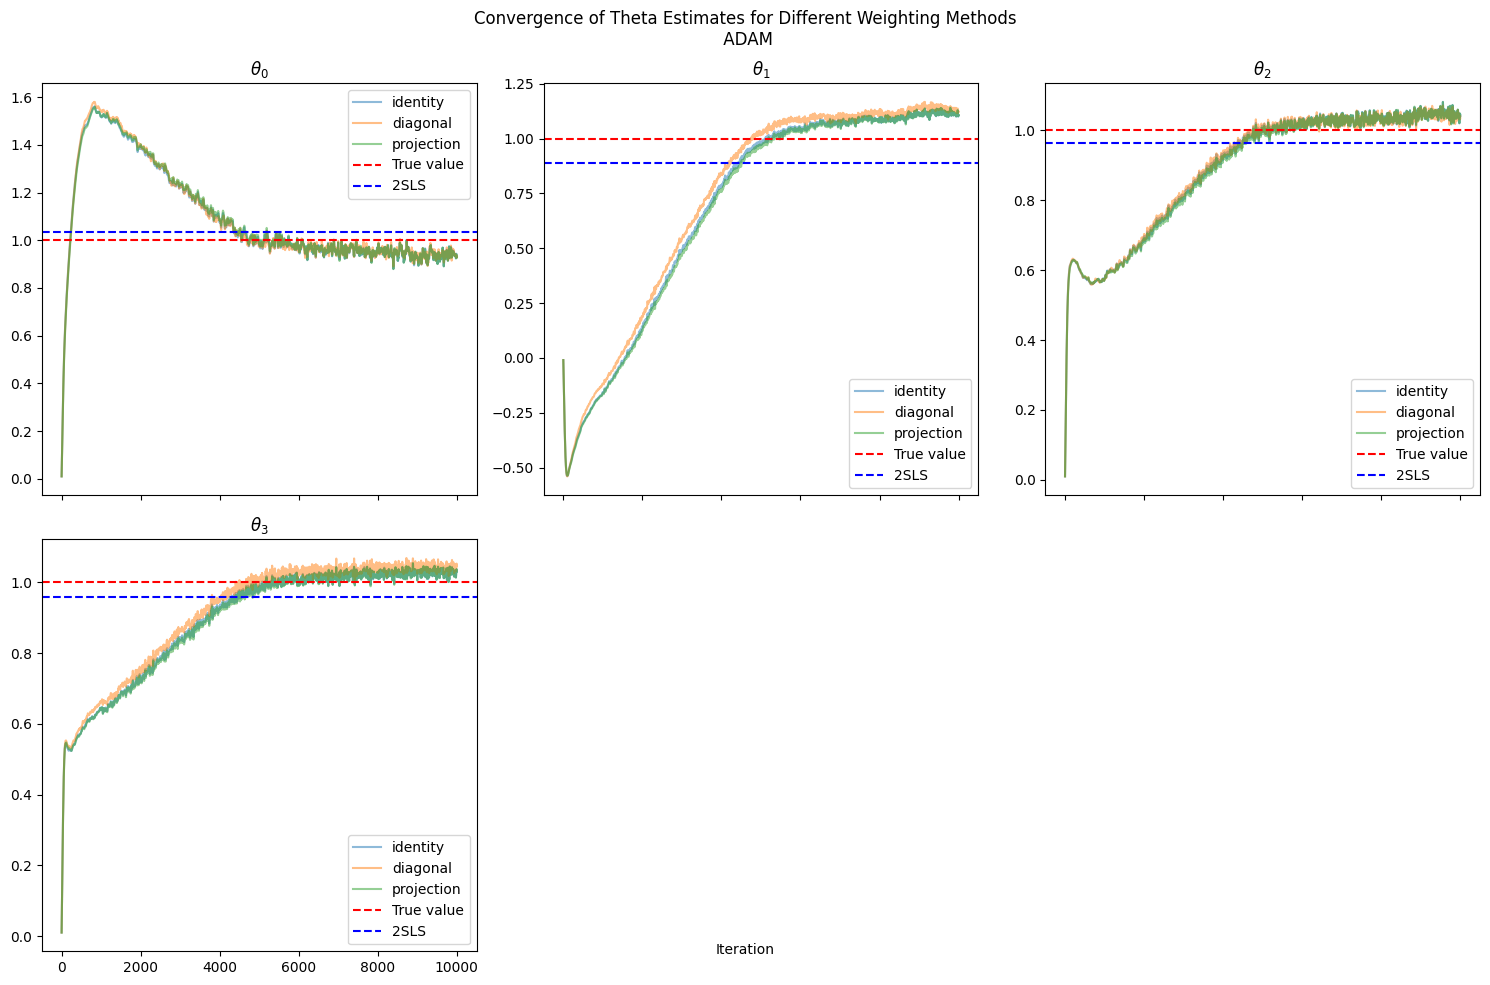

In [17]:
iv_convergence()

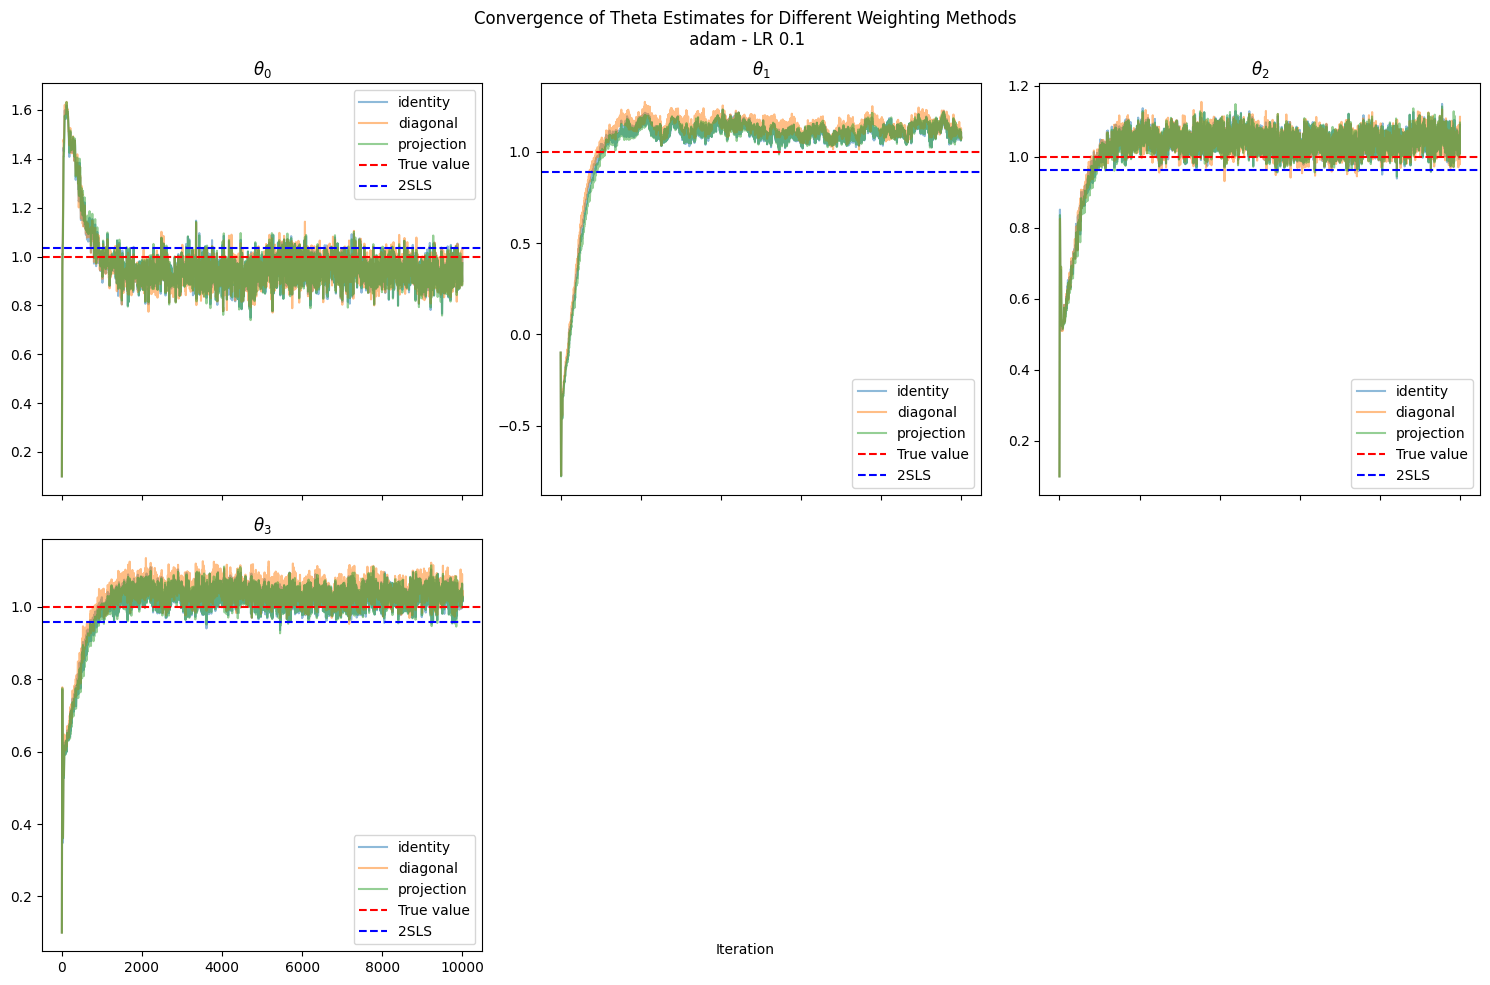

In [18]:
iv_convergence(optax.adam(0.1), "adam - LR 0.1")

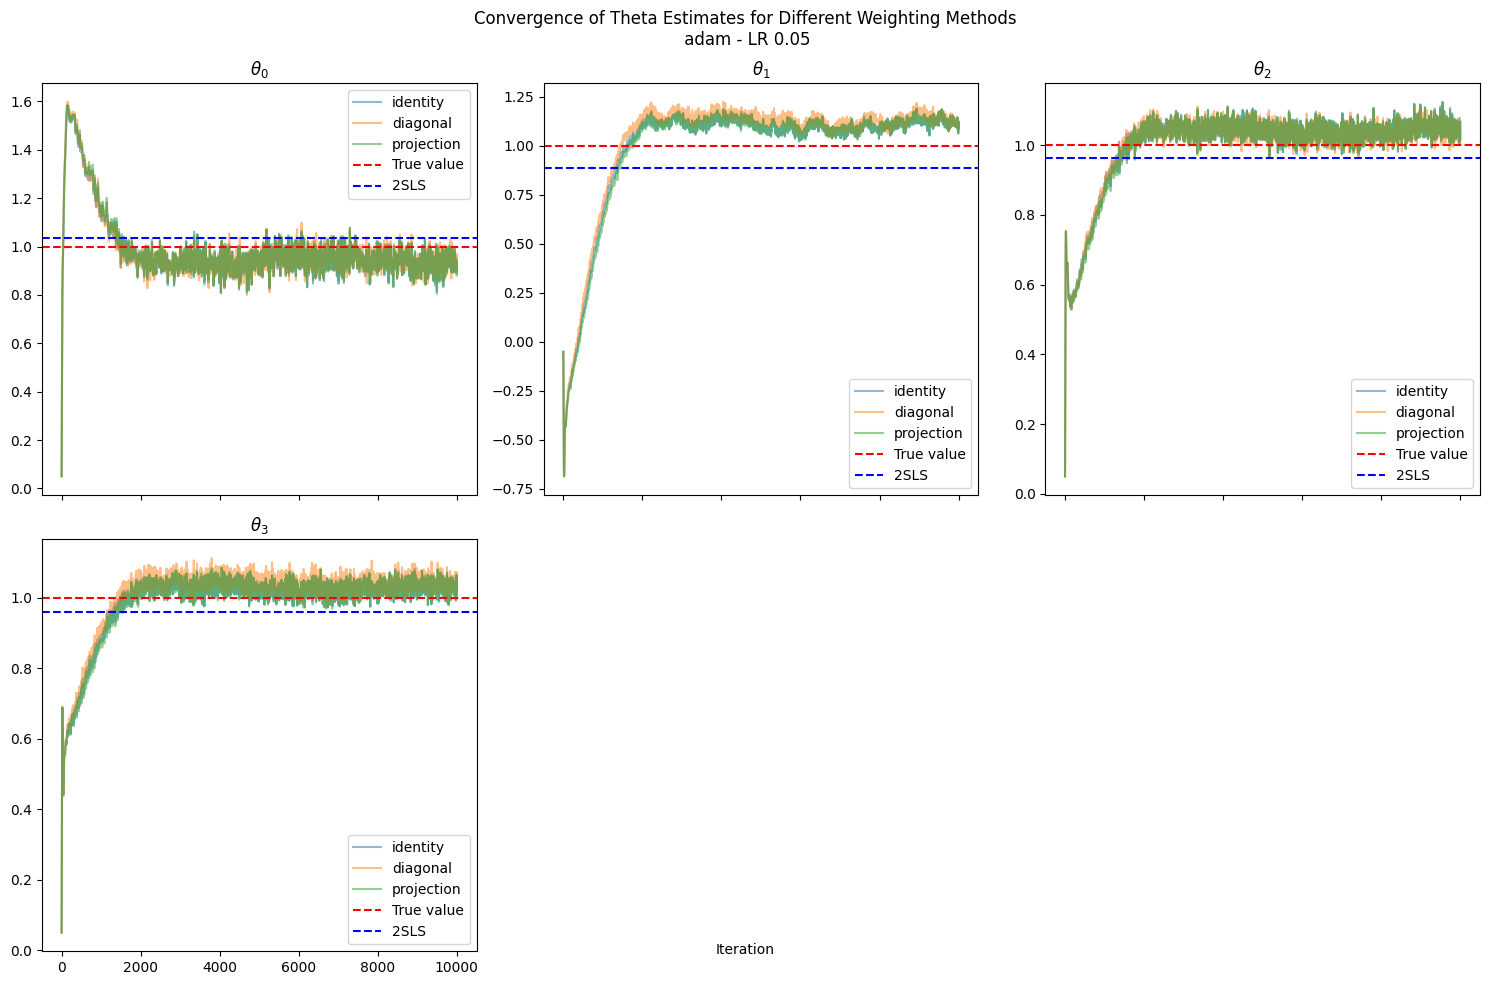

In [19]:
iv_convergence(optax.adam(0.05), "adam - LR 0.05")

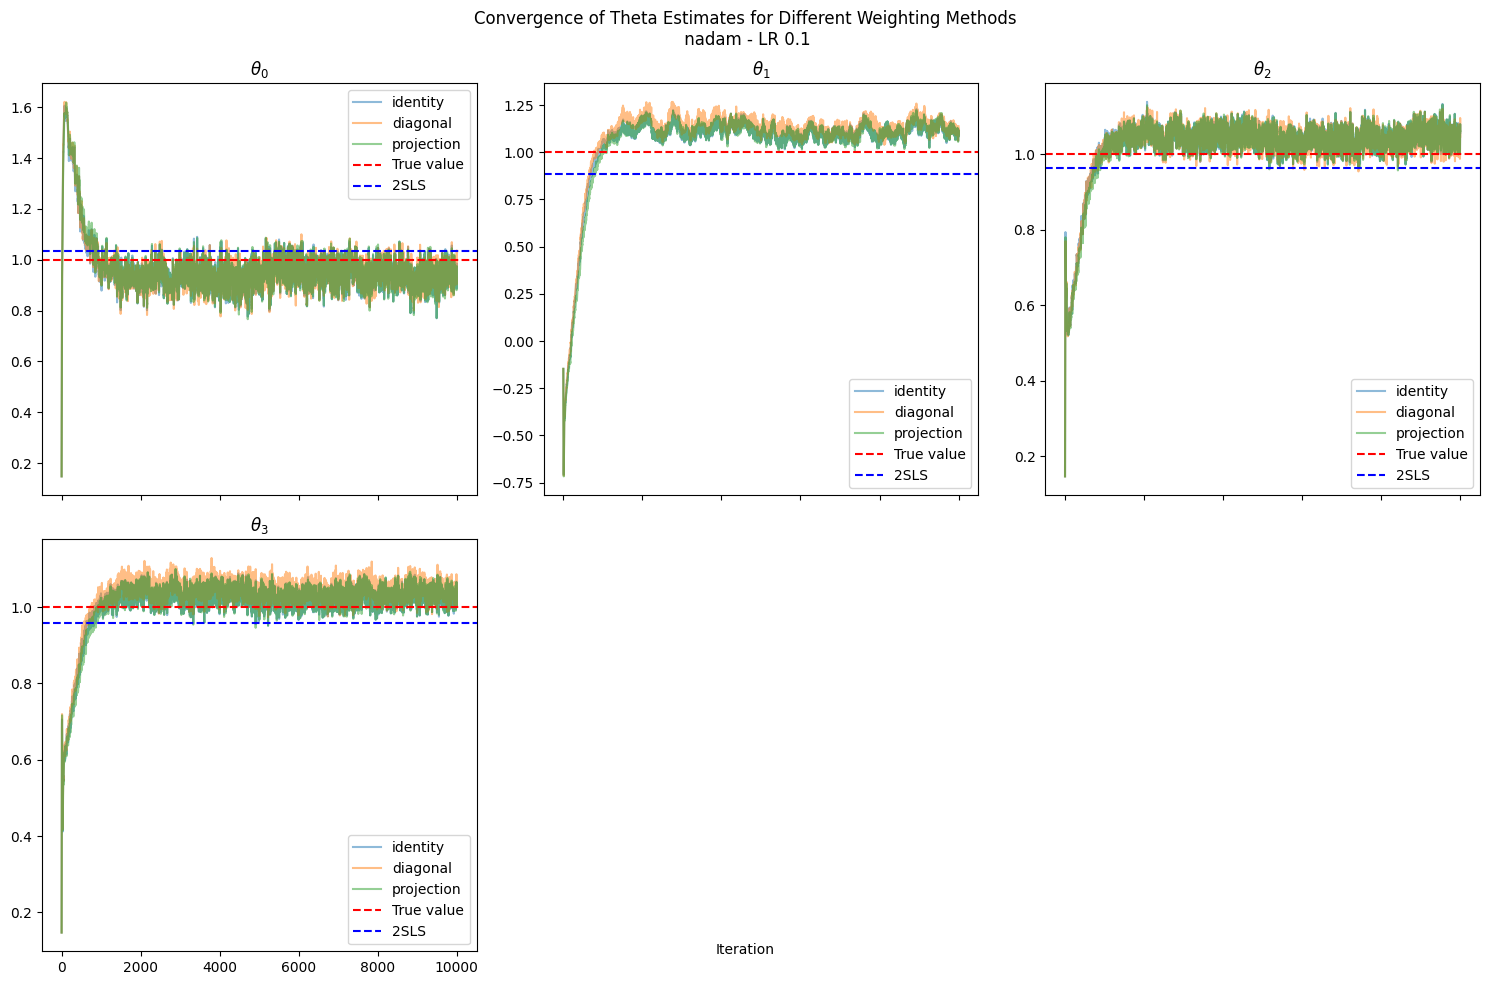

In [20]:
iv_convergence(optax.nadam(0.1), "nadam - LR 0.1")

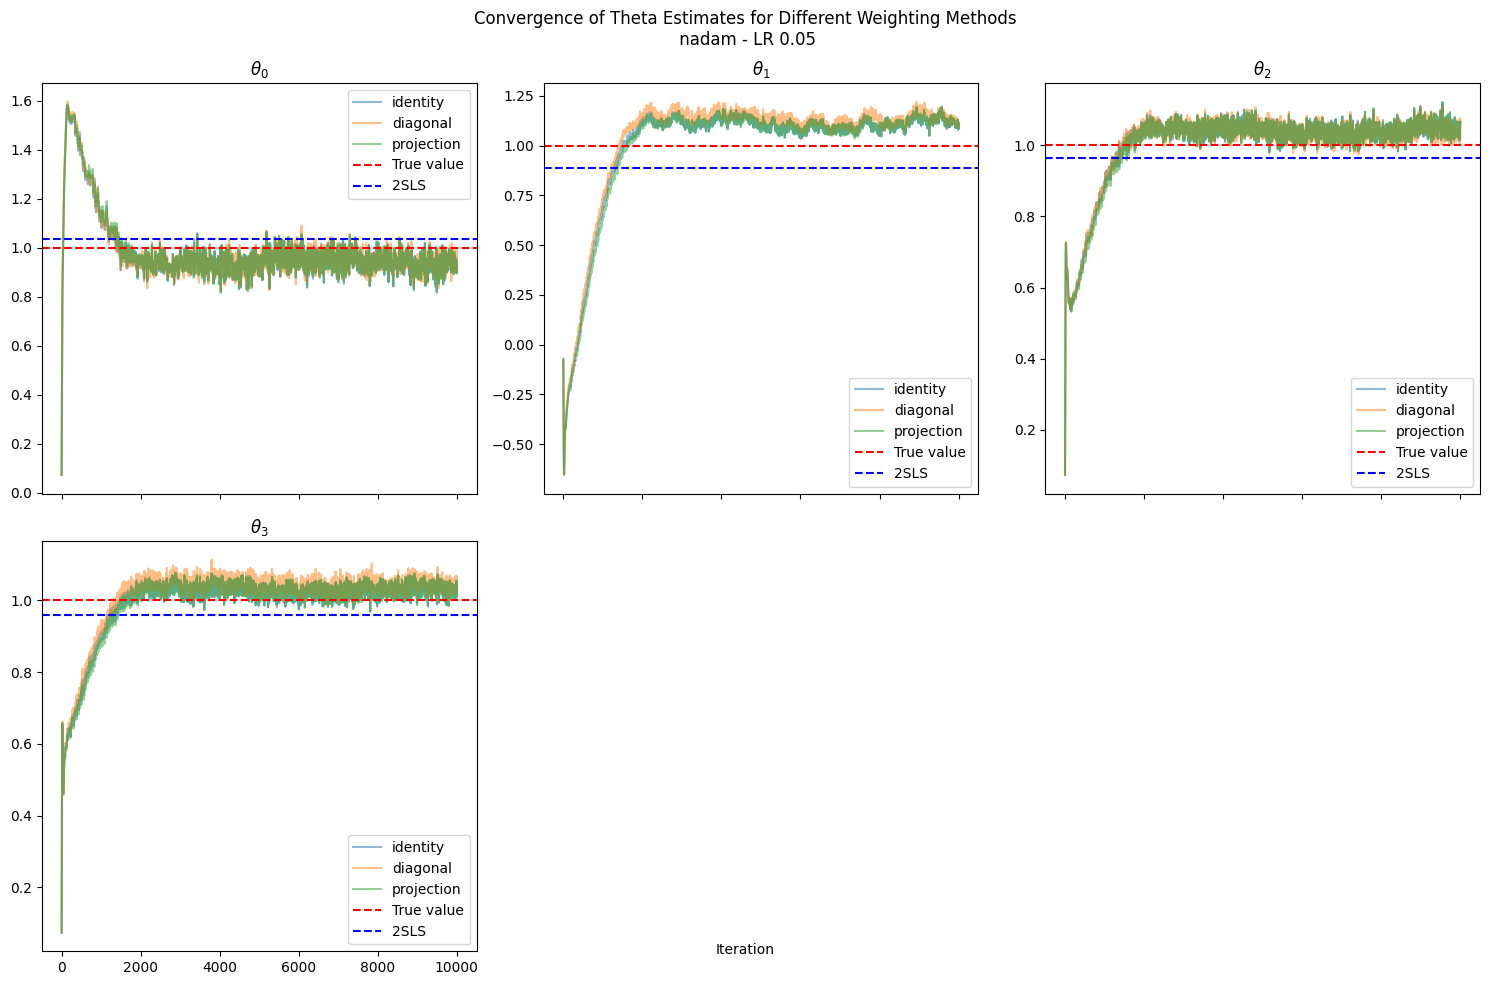

In [21]:
iv_convergence(optax.nadam(0.05), "nadam - LR 0.05")